In [1]:
import source_synphot.passband as passband
import source_synphot.io as io
import source_synphot.source
import astropy.table as at
from collections import OrderedDict
import pysynphot as S
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
import astropy.table as at
%matplotlib notebook

import pandas as pd

from scipy.optimize import minimize
from astropy.stats import sigma_clip
def myround(x, prec=2, base=.5):
    return round(base * round(float(x)/base),prec)
import sys
sys.path.append('../Sigma_clip/')
import sigmacut

In [2]:
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("Kep")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)
pbnames = pbs.keys()

In [3]:
def WD_specs(wds):
    wd_specs = {}
    for spec in wds:
        model_sed = source_synphot.source.pre_process_source(spec,None,'ps1g',None,Renorm=False)
        wd_specs[spec] = model_sed
    return wd_specs

In [4]:
source_table_file = io.get_pkgfile('sources/sourcetable.txt')
source_table = at.Table.read(source_table_file, format='ascii')

In [5]:
wds = [x['specname'] for x in source_table if ((x['specname'].startswith("wd")) & ('-' not in x['g']))]

In [6]:
model_sed = WD_specs(wds)
obs = pd.read_csv('../../data/WDdata/wds_ps1_ap.csv')

In [7]:
color1 = 'ps1g_ps1r'
color2 = 'ps1r_ps1i'
col1 = []
col2 = []
col3 = []
col4 = []
col5 = []
mg = []
mr = []
mi = []
mz = []

pbg, zpg = pbs['ps1g']
pbr, zpr = pbs['ps1r']
pbi, zpi = pbs['ps1i']
pbz, zpz = pbs['ps1z']
#pb5, zp5 = pbs[c5]
# construct color-color vectors
ind = []
for modelname in model_sed:
    model= model_sed[modelname]
    model = S.ArraySpectrum(model.wave, model.flux, name=modelname)
    mg += [source_synphot.passband.synphot(model, pbg,zpg)]
    mr += [source_synphot.passband.synphot(model, pbr,zpr)]
    mi += [source_synphot.passband.synphot(model, pbi,zpi)]
    mz += [source_synphot.passband.synphot(model, pbz,zpz)]
    
    for i in range(len(obs)):
        if modelname.split('/')[-1].split('.')[0] in obs['objid'].iloc[i].lower():
            ind += [i]
    
    #thiscol1 = source_synphot.passband.syncolor(model, pbg, pbr, zpg, zpr)
    #thiscol2 = source_synphot.passband.syncolor(model, pbg, pbi, zpg, zpi)
    #thiscol3 = source_synphot.passband.syncolor(model, pbr, pbi, zpr, zpi)
    #col1.append(thiscol1)
    #col2.append(thiscol2)
    #col3.append(thiscol3)
mg = np.array(mg)
mr = np.array(mr)
mi = np.array(mi)
mz = np.array(mz)
# select only useful objects
#good = ~np.isnan(col1)* ~np.isnan(col2)
#good = np.array(good)

In [14]:
mg

array([11.53419311, 12.82340624, 19.11639664, 19.82542391, 18.39007689,
       18.02228472, 19.7440702 , 18.93326407, 17.88586883, 18.45169017,
       18.68898012, 17.78399225, 17.06243517, 19.1268005 , 15.72671663,
       17.50062209, 18.86093979, 16.56501417, 18.67529155, 18.16214422,
       18.09687563])

In [8]:
observed = obs.iloc[ind]

In [16]:
observed.keys()

Index(['objid', 'ra', 'dec', 'Column1', 'raMean', 'decMean', 'raMeanErr',
       'decMeanErr', 'qualityFlag', 'gMeanPSFMag', 'gMeanPSFMagErr',
       'gMeanPSFMagNpt', 'gMeanApMag', 'gMeanApMagErr', 'gMeanApMagNpt',
       'rMeanPSFMag', 'rMeanPSFMagErr', 'rMeanPSFMagNpt', 'rMeanApMag',
       'rMeanApMagErr', 'rMeanApMagNpt', 'iMeanPSFMag', 'iMeanPSFMagErr',
       'iMeanPSFMagNpt', 'iMeanApMag', 'iMeanApMagErr', 'iMeanApMagNpt',
       'zMeanPSFMag', 'zMeanPSFMagErr', 'zMeanPSFMagNpt', 'zMeanApMag',
       'zMeanApMagErr', 'zMeanApMagNpt', 'yMeanPSFMag', 'yMeanPSFMagErr',
       'yMeanPSFMagNpt', 'yMeanApMag', 'yMeanApMagErr', 'yMeanApMagNpt',
       'rMeanKronMag', 'rMeanKronMagErr', 'nDetections', 'ng', 'nr', 'ni',
       'nz', 'ny', 'gFlags', 'gQfPerfect', 'rFlags', 'rQfPerfect', 'iFlags',
       'iQfPerfect', 'zFlags', 'zQfPerfect', 'yFlags', 'yQfPerfect',
       'primaryDetection', 'bestDetection'],
      dtype='object')

<IPython.core.display.Javascript object>


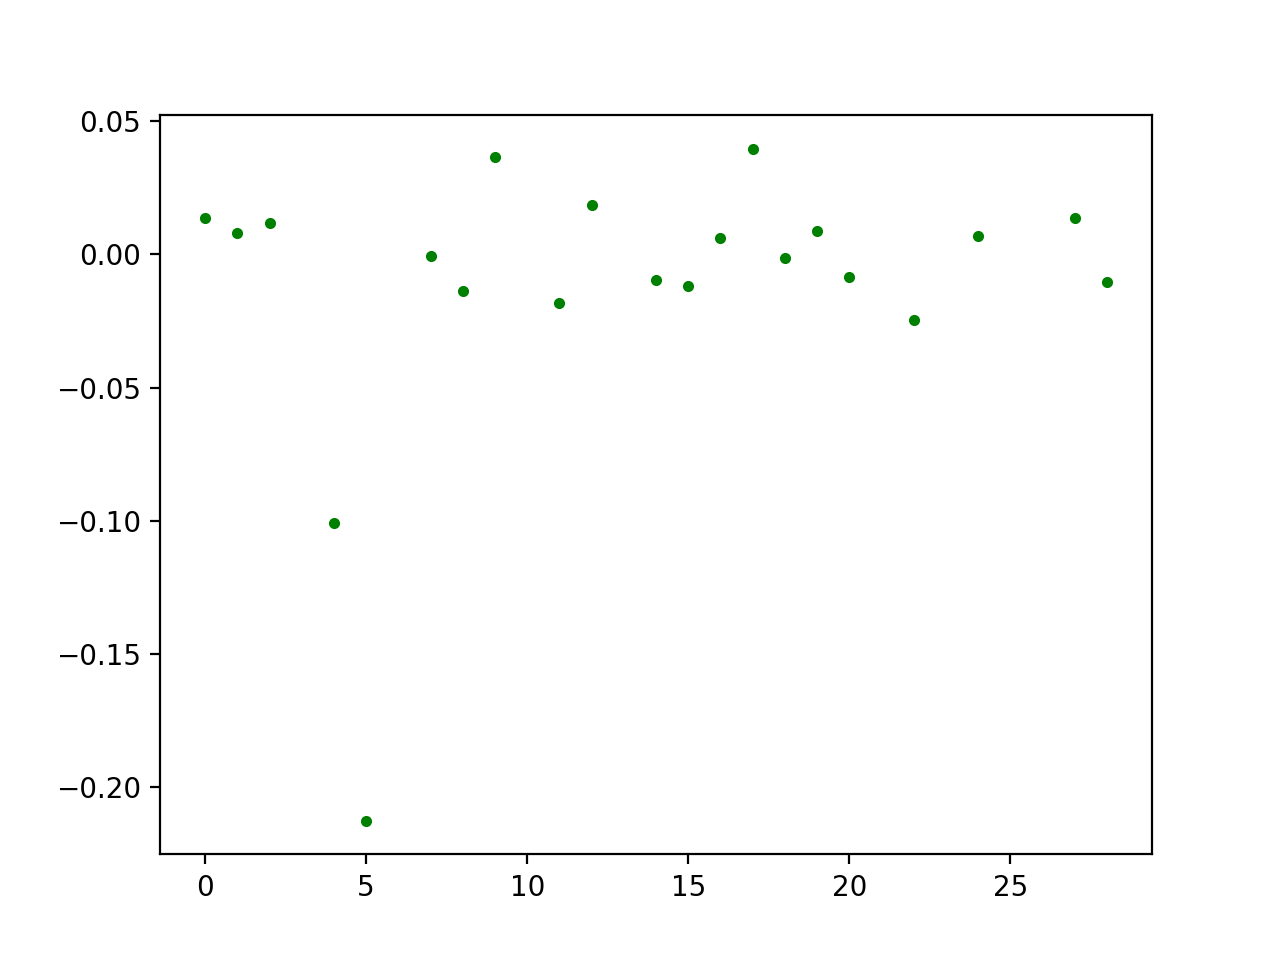

<IPython.core.display.Javascript object>


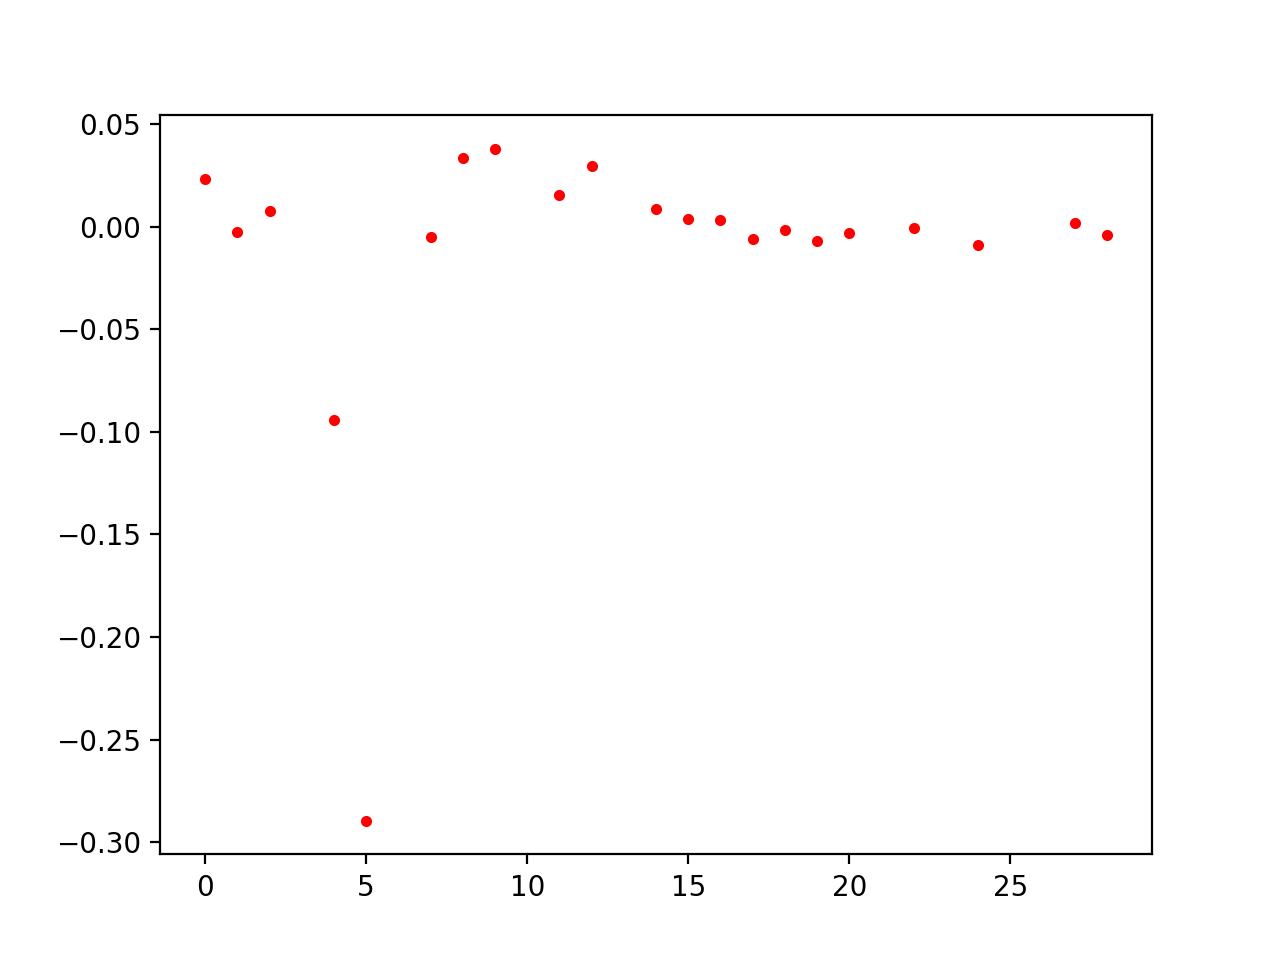

<IPython.core.display.Javascript object>


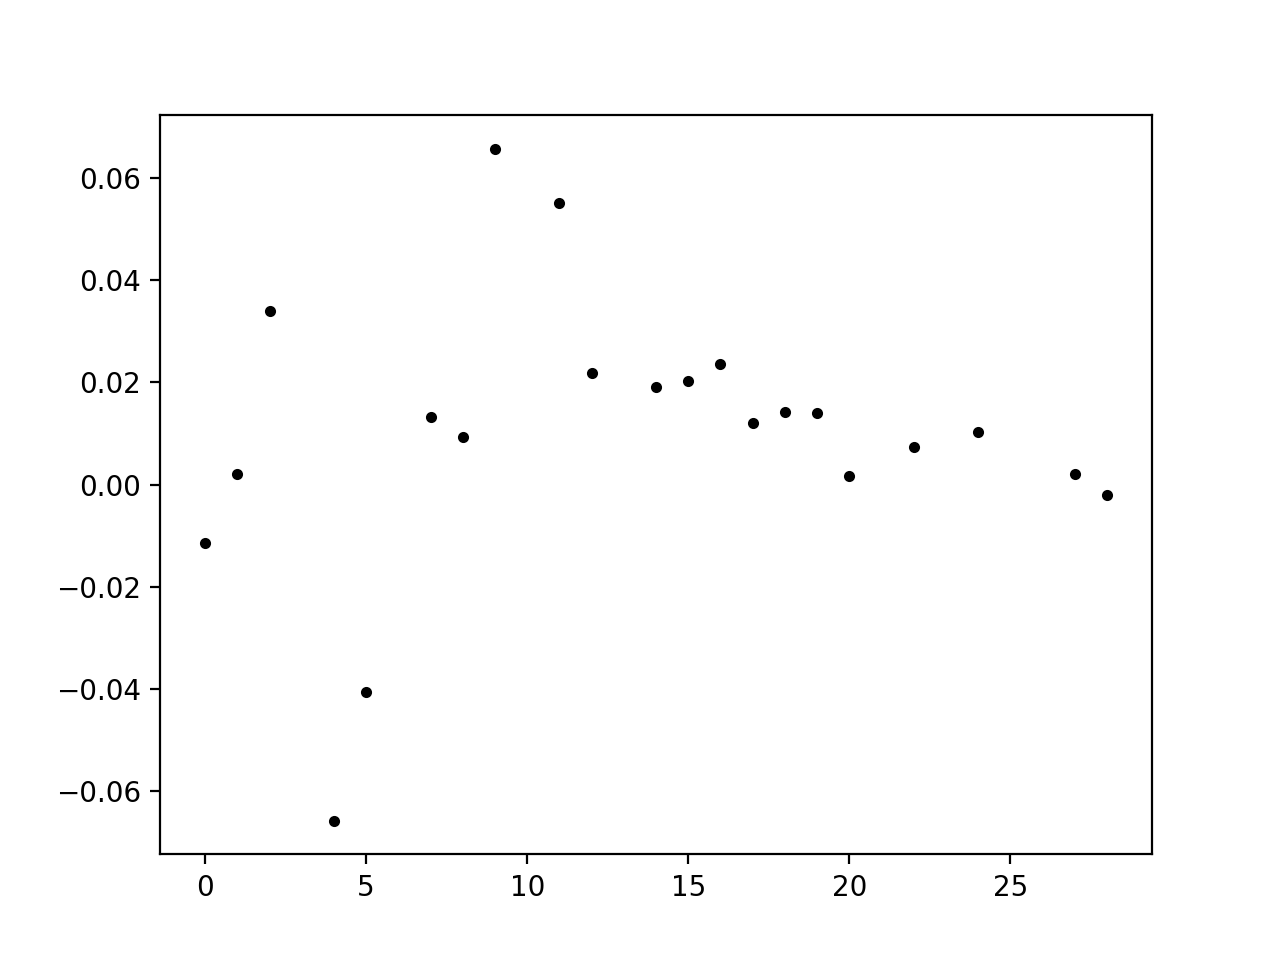

<IPython.core.display.Javascript object>


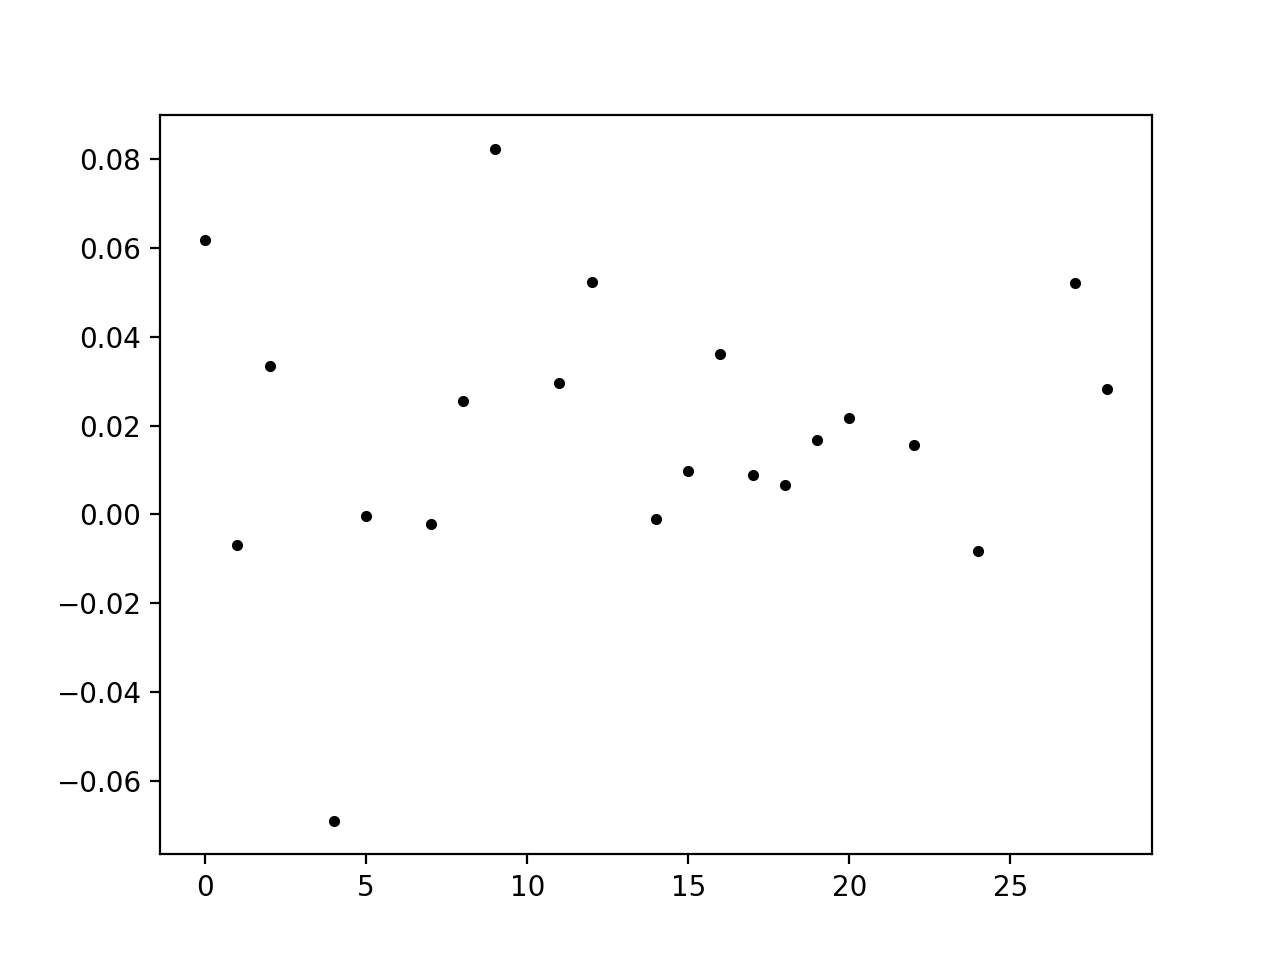

In [9]:
plt.figure()
plt.plot(mg-observed['gMeanPSFMag'],'g.')
#plt.plot(mg-o2['gMeanApMag'],'g+')
#plt.ylim(-.2,.2)
plt.figure()
plt.plot(mr-observed['rMeanPSFMag'],'r.')
#plt.plot(mg-o2['gMeanApMag'],'g+')
plt.figure()
plt.plot(mi-observed['iMeanPSFMag'],'k.')
#plt.plot(mg-o2['gMeanApMag'],'g+')
plt.figure()
plt.plot(mz-observed['zMeanPSFMag'],'k.')

In [10]:
def Armin_sigma(data,sigma=3,Verbose= False):
    calcaverage = sigmacut.calcaverageclass()
    calcaverage.calcaverage_sigmacutloop(data,verbose=3,Nsigma=sigma
                                         ,median_firstiteration=True,saveused=True)
    if Verbose:
        print("mean:%f (uncertainty:%f)" % (calcaverage.mean,calcaverage.mean_err))
    return data[calcaverage.use]

<IPython.core.display.Javascript object>


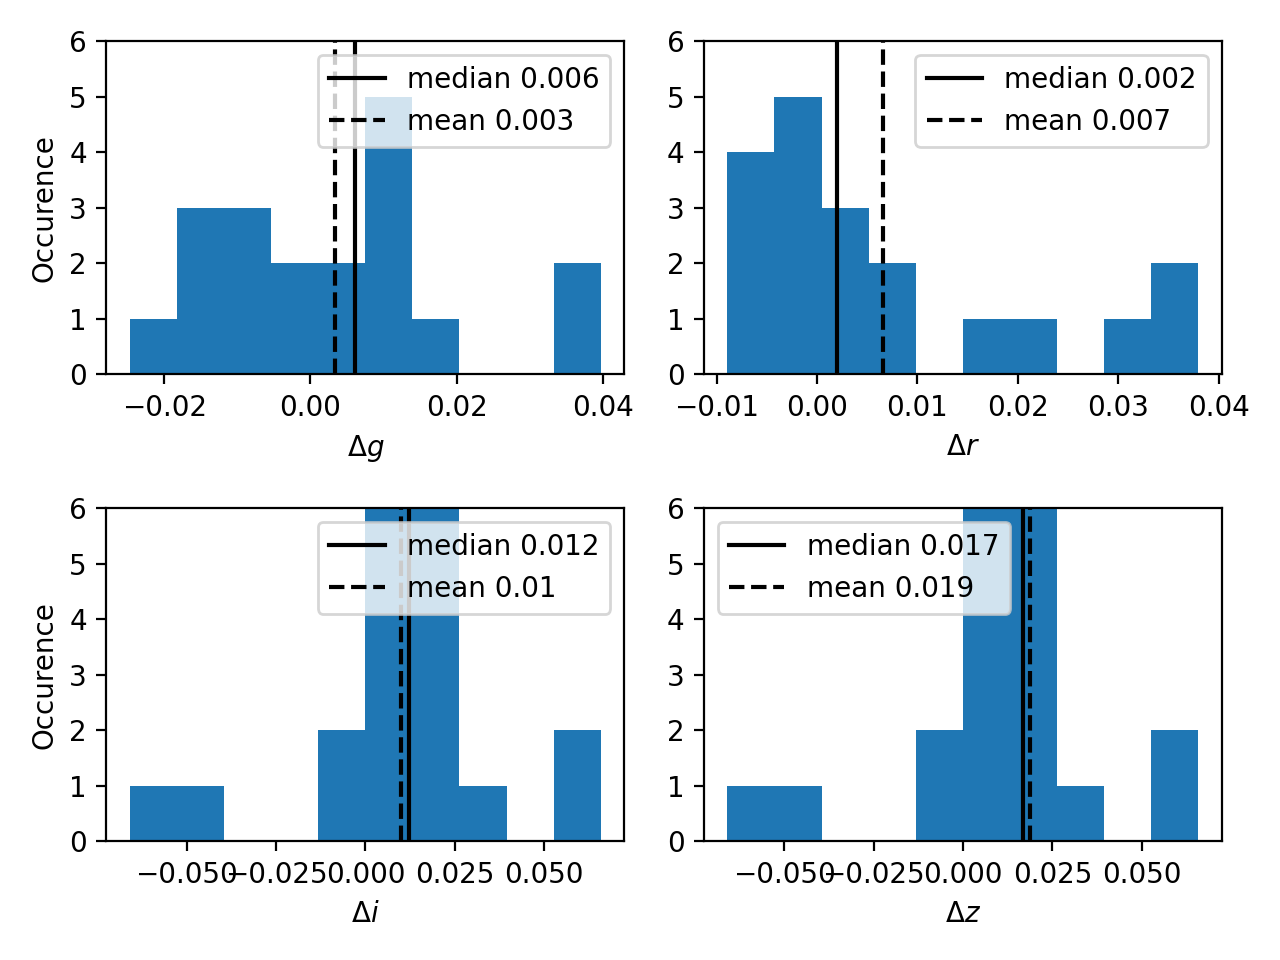

In [11]:
sigma = 3
plt.figure()#figsize=(8,4))
#plt.suptitle('Synth-obs')
plt.subplot(2,2,1)
gdiff = mg-observed['gMeanPSFMag']
gdiff = Armin_sigma(gdiff,sigma=sigma)
plt.hist(gdiff,bins=10)
med = np.nanmedian(gdiff)
std = np.std(gdiff)
#plt.fill_betweenx([0,5],med-std,med+std,color='grey',alpha=.2)
plt.axvline(np.nanmedian(gdiff),c='k',label='median ' + str(np.round(np.nanmedian(gdiff),3)))
plt.axvline(np.nanmean(gdiff),c='k',ls='--',label='mean ' + str(np.round(np.nanmean(gdiff),3)))
plt.legend()
plt.ylim(0,6)
plt.xlabel('$\Delta g$')
plt.ylabel('Occurence')


plt.subplot(2,2,2)
rdiff = mr-observed['rMeanPSFMag']
rdiff = Armin_sigma(rdiff,sigma=sigma)
plt.hist(rdiff,bins=10)
plt.axvline(np.nanmedian(rdiff),c='k',label='median ' + str(np.round(np.nanmedian(rdiff),3)))
plt.axvline(np.nanmean(rdiff),c='k',ls='--',label='mean ' + str(np.round(np.nanmean(rdiff),3)))
plt.ylim(0,6)

plt.xlabel('$\Delta r$')
plt.legend()


plt.subplot(2,2,3)
idiff = mi-observed['iMeanPSFMag']
idiff = Armin_sigma(idiff,sigma=sigma)
plt.hist(idiff,bins=10)
plt.axvline(np.nanmedian(idiff),c='k',label='median ' + str(np.round(np.nanmedian(idiff),3)))
plt.axvline(np.nanmean(idiff),c='k',ls='--',label='mean ' + str(np.round(np.nanmean(idiff),3)))
plt.ylim(0,6)

plt.xlabel('$\Delta i$')
plt.legend()
plt.ylabel('Occurence')
plt.legend()


plt.subplot(2,2,4)
zdiff = mz-observed['zMeanPSFMag']
zdiff = Armin_sigma(zdiff,sigma=sigma)
plt.hist(idiff,bins=10)
plt.axvline(np.nanmedian(zdiff),c='k',label='median ' + str(np.round(np.nanmedian(zdiff),3)))
plt.axvline(np.nanmean(zdiff),c='k',ls='--',label='mean ' + str(np.round(np.nanmean(zdiff),3)))
plt.ylim(0,6)
plt.xlabel('$\Delta z$')
plt.legend()

plt.tight_layout()
plt.savefig('WD_synthmag_psf.pdf')



<IPython.core.display.Javascript object>


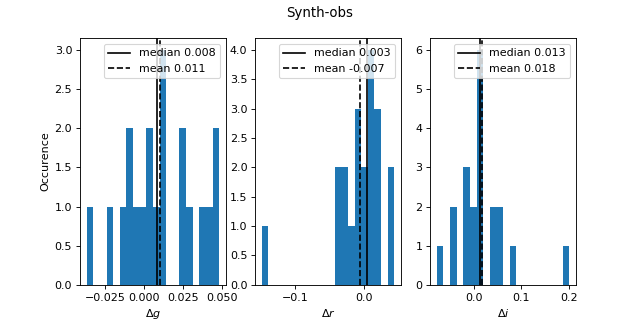

In [133]:
o2 = observed.copy()
o2.iloc[0] = np.nan
plt.figure(figsize=(8,4))
plt.suptitle('Synth-obs')
plt.subplot(1,3,1)
gdiff = mg-o2['gMeanApMag']
plt.hist(gdiff,bins=20)
plt.axvline(np.nanmedian(gdiff),c='k',label='median ' + str(np.round(np.nanmedian(gdiff),3)))
plt.axvline(np.nanmean(gdiff),c='k',ls='--',label='mean ' + str(np.round(np.nanmean(gdiff),3)))
plt.legend()
plt.xlabel('$\Delta g$')
plt.ylabel('Occurence')
plt.subplot(1,3,2)
rdiff = mr-o2['rMeanApMag']
plt.hist(rdiff,bins=20)
plt.axvline(np.nanmedian(rdiff),c='k',label='median ' + str(np.round(np.nanmedian(rdiff),3)))
plt.axvline(np.nanmean(rdiff),c='k',ls='--',label='mean ' + str(np.round(np.nanmean(rdiff),3)))
plt.xlabel('$\Delta r$')
plt.legend()
plt.subplot(1,3,3)
idiff = mi-o2['iMeanApMag']
plt.hist(idiff,bins=20)
plt.axvline(np.nanmedian(idiff),c='k',label='median ' + str(np.round(np.nanmedian(idiff),3)))
plt.axvline(np.nanmean(idiff),c='k',ls='--',label='mean ' + str(np.round(np.nanmean(idiff),3)))
plt.xlabel('$\Delta i$')
plt.legend()
plt.savefig('WD_synthmag_ap.png')

In [131]:
o2['gMeanApMag']

4    -999.000000
5      12.845800
0      19.092600
1      19.836800
2      18.351400
7      18.018400
8      19.780899
9      18.884800
11     17.895201
12     18.411501
14     18.693199
15     17.778999
16     17.052000
17     19.078300
18     15.720400
19     17.487400
20     18.860001
22     16.572800
24     18.652100
27     18.134399
28     18.084801
Name: gMeanApMag, dtype: float64

<IPython.core.display.Javascript object>


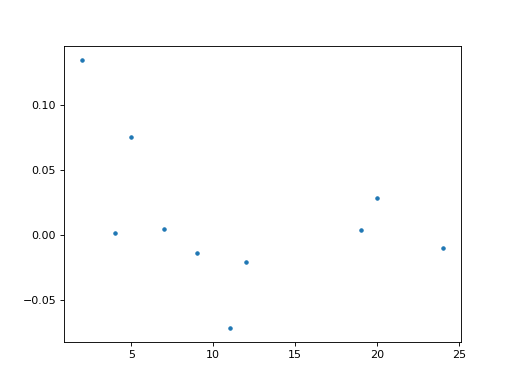

In [33]:
scatter = (mg-mr)-(observed['gMeanPSFMag']-observed['rMeanPSFMag'])
plt.figure()
plt.plot(scatter,'.')

# Sigma clip 

In [16]:
import sys
sys.path.append('../Sigma_clip/')
import sigmacut

In [17]:
def Armin_sigma(data,sigma=3,Verbose= False):
    calcaverage = sigmacut.calcaverageclass()
    calcaverage.calcaverage_sigmacutloop(gdiff,verbose=3,Nsigma=sigma
                                         ,median_firstiteration=True,saveused=True)
    if Verbose:
        print("mean:%f (uncertainty:%f)" % (calcaverage.mean,calcaverage.mean_err))
    return data[calcaverage.use]

In [44]:
print(calcaverage.use)

[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


<IPython.core.display.Javascript object>


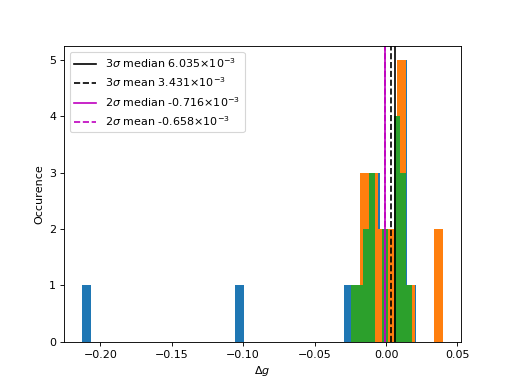

i:00 mean:-0.000716(0.012167) stdev:0.055758(0.008604) Nchanged:0 Nused:21 Nskipped:0
i:01 mean:-0.001781(0.006502) stdev:0.029076(0.004597) Nchanged:1 Nused:20 Nskipped:1
i:02 mean:0.003431(0.004000) stdev:0.017438(0.002829) Nchanged:1 Nused:19 Nskipped:2
i:03 mean:0.003431(0.004000) stdev:0.017438(0.002829) Nchanged:0 Nused:19 Nskipped:2
i:00 mean:-0.000716(0.012167) stdev:0.055758(0.008604) Nchanged:0 Nused:21 Nskipped:0
i:01 mean:-0.001781(0.006502) stdev:0.029076(0.004597) Nchanged:1 Nused:20 Nskipped:1
i:02 mean:0.003431(0.004000) stdev:0.017438(0.002829) Nchanged:1 Nused:19 Nskipped:2
i:03 mean:0.001416(0.003639) stdev:0.015439(0.002573) Nchanged:1 Nused:18 Nskipped:3
i:04 mean:-0.000658(0.003152) stdev:0.012996(0.002229) Nchanged:1 Nused:17 Nskipped:4
i:05 mean:-0.000658(0.003152) stdev:0.012996(0.002229) Nchanged:0 Nused:17 Nskipped:4
i:00 mean:-0.000716(0.012167) stdev:0.055758(0.008604) Nchanged:0 Nused:21 Nskipped:0
i:01 mean:-0.001781(0.006502) stdev:0.029076(0.004597) Nch

Text(0, 0.5, 'Occurence')

In [67]:
plt.figure()
plt.hist(gdiff,bins=40)
plt.hist(gdiff[sigma_mask(gdiff)],bins=10)
plt.hist(gdiff[sigma_mask(gdiff,sigma=2)],bins=10,alpha = 1)
plt.axvline(np.nanmedian(gdiff[sigma_mask(gdiff,sigma=3)]),c='k',label='3$\sigma$ median ' + str(np.round(np.nanmedian(gdiff[sigma_mask(gdiff,sigma=3)])*10**3,3))+r'$\times10^{-3}$')
plt.axvline(np.nanmean(gdiff[sigma_mask(gdiff,sigma=3)]),c='k',ls='--',label='3$\sigma$ mean ' + str(np.round(np.nanmean(gdiff[sigma_mask(gdiff,sigma=3)])*10**3,3))+r'$\times10^{-3}$')
plt.axvline(np.nanmedian(gdiff[sigma_mask(gdiff,sigma=2)]),c='m',label='2$\sigma$ median ' + str(np.round(np.nanmedian(gdiff[sigma_mask(gdiff,sigma=2)])*10**3,3))+r'$\times10^{-3}$')
plt.axvline(np.nanmean(gdiff[sigma_mask(gdiff,sigma=2)]),c='m',ls='--',label='2$\sigma$ mean ' + str(np.round(np.nanmean(gdiff[sigma_mask(gdiff,sigma=2)])*10**3,3))+r'$\times10^{-3}$')
plt.legend()
plt.xlabel('$\Delta g$')
plt.ylabel('Occurence')

# Test values Gautham gave Elizabeth

In [13]:
ez = pd.read_csv('../PS1Calibration/GauthamsWDsSDSSSpecPhotoAll.csv')

In [15]:
observed.keys()

Index(['objid', 'ra', 'dec', 'Column1', 'raMean', 'decMean', 'raMeanErr',
       'decMeanErr', 'qualityFlag', 'gMeanPSFMag', 'gMeanPSFMagErr',
       'gMeanPSFMagNpt', 'gMeanApMag', 'gMeanApMagErr', 'gMeanApMagNpt',
       'rMeanPSFMag', 'rMeanPSFMagErr', 'rMeanPSFMagNpt', 'rMeanApMag',
       'rMeanApMagErr', 'rMeanApMagNpt', 'iMeanPSFMag', 'iMeanPSFMagErr',
       'iMeanPSFMagNpt', 'iMeanApMag', 'iMeanApMagErr', 'iMeanApMagNpt',
       'zMeanPSFMag', 'zMeanPSFMagErr', 'zMeanPSFMagNpt', 'zMeanApMag',
       'zMeanApMagErr', 'zMeanApMagNpt', 'yMeanPSFMag', 'yMeanPSFMagErr',
       'yMeanPSFMagNpt', 'yMeanApMag', 'yMeanApMagErr', 'yMeanApMagNpt',
       'rMeanKronMag', 'rMeanKronMagErr', 'nDetections', 'ng', 'nr', 'ni',
       'nz', 'ny', 'gFlags', 'gQfPerfect', 'rFlags', 'rQfPerfect', 'iFlags',
       'iQfPerfect', 'zFlags', 'zQfPerfect', 'yFlags', 'yQfPerfect',
       'primaryDetection', 'bestDetection'],
      dtype='object')

In [18]:
observed['Column1'].astype(int)

4     171391000000000000
5     127061000000000000
0     107580000000000000
1      97850400000000000
2     148510000000000000
7     146681000000000000
8     117031000000000000
9     107352000000000000
11     87401700000000000
12    155932000000000000
14    110432000000000000
15    162762000000000000
16    120252000000000000
17    104112000000000000
18    108952000000000000
19    174922000000000000
20    108942000000000000
22    202683000000000000
24    101083000000000000
27    108224000000000000
28    153514000000000000
Name: Column1, dtype: int64

In [17]:
ez

,objID,ra,dec,psfMag_u,psfMagErr_u,psfMag_g,psfMagErr_g,psfMag_r,psfMagErr_r,psfMag_i,psfMagErr_i,psfMag_z,psfMagErr_z
0,1237663783667433549,15.842440,-0.346578,18.62846,0.044882,19.05516,0.027628,19.55324,0.020680,19.91686,0.029433,20.40777,0.116449
1,1237652900764123274,37.071543,-8.454543,19.80315,0.042351,19.77881,0.024162,20.15401,0.028606,20.40517,0.040040,21.20803,0.360998
2,1237670961627726034,42.229020,33.763432,18.11372,0.021608,18.35413,0.018358,18.72370,0.016541,18.96219,0.016000,19.23966,0.052237
3,1237674366990549248,111.969850,32.237828,17.57158,0.015442,17.95434,0.009769,18.45526,0.010095,18.76415,0.013920,19.14044,0.041128
4,1237661069773701663,123.786590,7.529386,19.40528,0.028720,19.67382,0.018791,20.20403,0.023858,20.54331,0.033495,20.64594,0.135518
5,1237648720683401246,156.128870,-0.535287,18.57872,0.027818,18.88727,0.022157,19.30700,0.022401,19.60316,0.027829,19.80272,0.077360
6,1237671139862052954,167.747660,-17.165052,17.47415,0.017478,17.85269,0.019315,18.31740,0.016677,18.62341,0.017995,18.91840,0.038758
7,1237664670050484289,167.863790,39.941134,17.98302,0.025967,18.40715,0.019339,18.92246,0.013945,19.29059,0.018690,19.63848,0.065712
8,1237651735757717521,181.710040,2.028451,18.54170,0.024224,18.65785,0.023313,19.03780,0.022155,19.33539,0.027436,19.72945,0.099244
9,1237661852005826602,183.521300,45.638489,17.36949,0.024922,17.71919,0.024470,18.20780,0.018978,18.54297,0.021294,18.80947,0.036156


In [35]:
ram = observed['ra']
dem = observed['dec']
rag = ez['ra']
deg = ez['dec']
dist = np.zeros((len(ram),len(deg)))
dist = dist + np.sqrt((deg[np.newaxis,:] - dem[:,np.newaxis])**2 + (rag[np.newaxis,:] - ram[:,np.newaxis])**2)

ind = np.argmin(dist,axis=0)
indo = np.nanmin(dist,axis=0) < .01

In [36]:
ind[indo]

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20])

In [39]:
ez

,objID,ra,dec,psfMag_u,psfMagErr_u,psfMag_g,psfMagErr_g,psfMag_r,psfMagErr_r,psfMag_i,psfMagErr_i,psfMag_z,psfMagErr_z
0,1237663783667433549,15.842440,-0.346578,18.62846,0.044882,19.05516,0.027628,19.55324,0.020680,19.91686,0.029433,20.40777,0.116449
1,1237652900764123274,37.071543,-8.454543,19.80315,0.042351,19.77881,0.024162,20.15401,0.028606,20.40517,0.040040,21.20803,0.360998
2,1237670961627726034,42.229020,33.763432,18.11372,0.021608,18.35413,0.018358,18.72370,0.016541,18.96219,0.016000,19.23966,0.052237
3,1237674366990549248,111.969850,32.237828,17.57158,0.015442,17.95434,0.009769,18.45526,0.010095,18.76415,0.013920,19.14044,0.041128
4,1237661069773701663,123.786590,7.529386,19.40528,0.028720,19.67382,0.018791,20.20403,0.023858,20.54331,0.033495,20.64594,0.135518
5,1237648720683401246,156.128870,-0.535287,18.57872,0.027818,18.88727,0.022157,19.30700,0.022401,19.60316,0.027829,19.80272,0.077360
6,1237671139862052954,167.747660,-17.165052,17.47415,0.017478,17.85269,0.019315,18.31740,0.016677,18.62341,0.017995,18.91840,0.038758
7,1237664670050484289,167.863790,39.941134,17.98302,0.025967,18.40715,0.019339,18.92246,0.013945,19.29059,0.018690,19.63848,0.065712
8,1237651735757717521,181.710040,2.028451,18.54170,0.024224,18.65785,0.023313,19.03780,0.022155,19.33539,0.027436,19.72945,0.099244
9,1237661852005826602,183.521300,45.638489,17.36949,0.024922,17.71919,0.024470,18.20780,0.018978,18.54297,0.021294,18.80947,0.036156


In [38]:
observed.iloc[ind]

,objid,ra,dec,Column1,raMean,decMean,raMeanErr,decMeanErr,qualityFlag,gMeanPSFMag,...,rFlags,rQfPerfect,iFlags,iQfPerfect,zFlags,zQfPerfect,yFlags,yQfPerfect,primaryDetection,bestDetection
0,SDSSJ010322,15.842462,-0.346592,1.075800e+17,15.842492,-0.346616,0.01430,0.02700,52,19.102699,...,115000,0.998756,115000,0.999435,115000,0.999213,115000,0.997383,1,1
1,SDSSJ022817,37.071537,-8.454558,9.785040e+16,37.071594,-8.454529,0.01438,0.00927,52,19.817200,...,115000,0.999519,115000,0.998637,115000,0.999285,115000,0.997530,1,1
2,SDSSJ024854,42.229000,33.763417,1.485100e+17,42.229015,33.763400,0.00525,0.00475,52,18.378300,...,115000,0.999355,115000,0.999736,115000,0.999711,115000,0.998603,1,1
7,SDSSJ072752,111.969833,32.237806,1.466810e+17,111.969820,32.237791,0.00638,0.00361,52,18.023001,...,115000,0.999691,115000,0.998756,115000,0.999319,115000,0.998966,1,1
8,SDSSJ081508,123.786579,7.529390,1.170310e+17,123.786590,7.529379,0.02835,0.01307,52,19.757700,...,115000,0.999658,115000,0.999152,115000,0.998896,16416,-999.000000,1,1
9,SDSSJ102430,156.128883,-0.535286,1.073520e+17,156.128827,-0.535310,0.00931,0.00992,52,18.896601,...,115000,0.999590,115000,0.998312,115000,0.998920,115000,0.999136,1,1
11,SDSSJ111059,167.747625,-17.165028,8.740170e+16,167.747647,-17.165082,0.01152,0.00978,52,17.904100,...,115000,0.999417,115000,0.999325,115000,0.999707,115000,0.999671,1,1
12,SDSSJ111127,167.863750,39.941111,1.559320e+17,167.863795,39.941135,0.00790,0.00821,52,18.433201,...,115000,0.999299,115000,0.999620,115000,0.999302,115000,0.998176,1,1
14,SDSSJ120650,181.710033,2.028461,1.104320e+17,181.710039,2.028382,0.01422,0.01182,52,18.698601,...,115000,0.999384,115000,0.999100,115000,0.999671,115000,0.999666,1,1
15,SDSSJ121405,183.521292,45.638472,1.627620e+17,183.521296,45.638502,0.00460,0.00679,52,17.795900,...,115000,0.999658,115000,0.999757,115000,0.999466,115000,0.999728,1,1
